# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
import cv2
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
%matplotlib inline

# Loading the Data

In [2]:
dataset_path= Path(r'./Fish_Dataset/Fish_Dataset')
file_path= list(dataset_path.glob(r'**/*.png'))

In [ ]:
#creating labels using folder's name
labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

file_path= pd.Series(file_path).astype(str)
labels= pd.Series(labels)
df= pd.concat([file_path,labels],axis=1)
df.columns= ['image','label']

In [ ]:
#removing GT files
df = df[ df['label'].apply(lambda x: x[-2:]!='GT') ]


In [ ]:
#resampling
df=df.sample(frac=1).reset_index(drop= True)

In [25]:
df.head()

,image,label
0,Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Se...,Red Sea Bream
1,Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00799.png,Shrimp
2,Fish_Dataset/Fish_Dataset/Black Sea Sprat/Blac...,Black Sea Sprat
3,Fish_Dataset/Fish_Dataset/Striped Red Mullet/S...,Striped Red Mullet
4,Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt...,Gilt-Head Bream


# Plotting some of the images

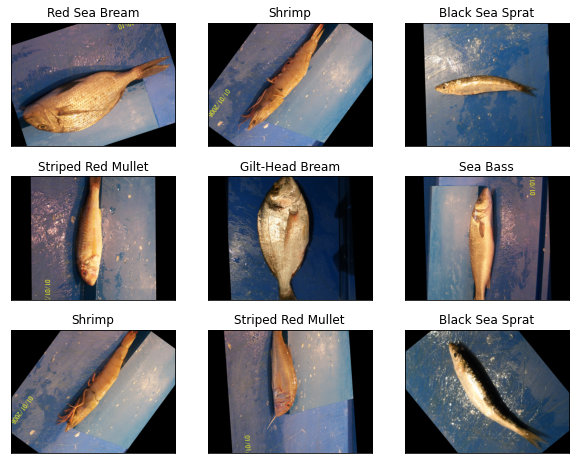

In [3]:
fig,axes= plt.subplots(nrows= 3, ncols= 3, figsize=(10,8),subplot_kw={'xticks':[],'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])

plt.show()                       

# Splitting the Data

In [4]:
x_train, x_test = train_test_split(df, test_size=0.25)
x_val, x_test = train_test_split(x_test, test_size=0.6)

print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (6750, 2)
Shape of test data (1350, 2)
Shape of validation data (900, 2)


# Data Augmentation

In [5]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


# Building the  Model

In [13]:
input_shape= (200,200,3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 46, 46, 16)        4624      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 16)       

# Training the Model

In [14]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

history = model.fit(train, validation_data=val, epochs=10, callbacks=callback)


Epoch 1/10
211/211 [==============================] - 336s 2s/step - loss: 2.0394 - accuracy: 0.1832 - val_loss: 1.4720 - val_accuracy: 0.4389
Epoch 2/10
211/211 [==============================] - 331s 2s/step - loss: 1.4225 - accuracy: 0.4345 - val_loss: 0.9872 - val_accuracy: 0.6111
Epoch 3/10
211/211 [==============================] - 331s 2s/step - loss: 1.0928 - accuracy: 0.5647 - val_loss: 0.9392 - val_accuracy: 0.6344
Epoch 4/10
211/211 [==============================] - 329s 2s/step - loss: 0.9227 - accuracy: 0.6170 - val_loss: 0.7956 - val_accuracy: 0.6722
Epoch 5/10
211/211 [==============================] - 321s 2s/step - loss: 0.8217 - accuracy: 0.6694 - val_loss: 0.7329 - val_accuracy: 0.7089
Epoch 6/10
211/211 [==============================] - 323s 2s/step - loss: 0.7045 - accuracy: 0.7267 - val_loss: 0.5309 - val_accuracy: 0.8089
Epoch 7/10
211/211 [==============================] - 325s 2s/step - loss: 0.5765 - accuracy: 0.7907 - val_loss: 0.4919 - val_accuracy: 0.8256

In [15]:
history = model.fit(train, validation_data=val, epochs=10, callbacks=callback)


Epoch 1/10
211/211 [==============================] - 319s 2s/step - loss: 0.3304 - accuracy: 0.8850 - val_loss: 0.3115 - val_accuracy: 0.8811
Epoch 2/10
211/211 [==============================] - 333s 2s/step - loss: 0.3172 - accuracy: 0.8821 - val_loss: 0.2397 - val_accuracy: 0.9189
Epoch 3/10
211/211 [==============================] - 328s 2s/step - loss: 0.2903 - accuracy: 0.8982 - val_loss: 0.3244 - val_accuracy: 0.8878
Epoch 4/10
211/211 [==============================] - 346s 2s/step - loss: 0.2715 - accuracy: 0.9053 - val_loss: 0.1647 - val_accuracy: 0.9478
Epoch 5/10
211/211 [==============================] - 376s 2s/step - loss: 0.2345 - accuracy: 0.9194 - val_loss: 0.2317 - val_accuracy: 0.9078
Epoch 6/10
211/211 [==============================] - 355s 2s/step - loss: 0.2275 - accuracy: 0.9178 - val_loss: 0.1845 - val_accuracy: 0.9356
Epoch 7/10
211/211 [==============================] - 382s 2s/step - loss: 0.2104 - accuracy: 0.9244 - val_loss: 0.2108 - val_accuracy: 0.9222

# Model Evaluation

In [19]:
test_accuracy = model.evaluate(test)[1]

43/43 [==============================] - 54s 1s/step - loss: 0.1917 - accuracy: 0.9274


In [20]:
print("Test Accuracy = {}".format(test_accuracy))

Test Accuracy = 0.9274073839187622


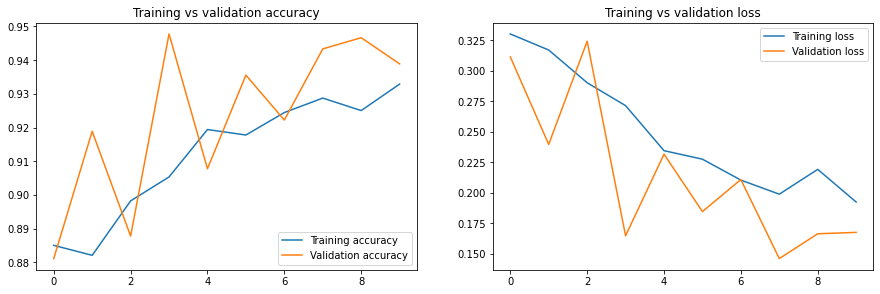

In [23]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()